# Signal Processing for EEG
- Chris Lee-Messer
- [link to notebook](http://localhost:8888/notebooks/signalprocessinglectures/lecture_01/lecture1.ipynb
- [notebook reop on github](https://github.com/cleemesser/signalprocessinglectures)
- Much of the material is from Allen Downy's [ThinkDSP book ](https://github.com/AllenDowney/ThinkDSP)

In [1]:
# imports
import pathlib
import numpy as np
import bokeh
from bokeh.io import output_notebook
import matplotlib.pyplot as plt
output_notebook()

Loading BokehJS ...

In [2]:
import eegvis
import eegvis.nb_eegview
import eegml_signal
import eeghdf
import thinkdsp # always keep this with lecture

In [3]:
lecture_dir = pathlib.Path(thinkdsp.__file__).parent
DATA_PATH = lecture_dir.parent / "data"

In [4]:
#NEO_DIR  = '/home/clee/code/eegml/data/stevenson_neonatalsz_2019/hdf'
NEO_DIR  = str(DATA_PATH).replace('\\',r'/').replace(r'C:','')
NEO_PATH = pathlib.Path(NEO_DIR)
NEO_DIR, NEO_PATH


('/Users/clee/code/eegml/signalprocessinglectures/data',
 WindowsPath('/Users/clee/code/eegml/signalprocessinglectures/data'))

In [5]:
fn = NEO_DIR + r'/eeg11.eeg.h5'
fn = r"..\data\eeg1.eeg.h5"
pn = NEO_PATH / "eeg11.eeg.h5"
fn = NEO_DIR  = '/home/clee/code/eegml/data/stevenson_neonatalsz_2019/hdf'
fn = r"C:\Users\clee\code\eegml\stevenson_neonatalsz\hdf\eeg11.eeg.h5"
fn2 = r"C:\Users\clee\code\eegml\stevenson_neonatalsz\hdf\eeg5.eeg.h5"

## Niedermeyer Book covers these things in detail
But it seems a bit dry to me, and not interactive.



## Signals


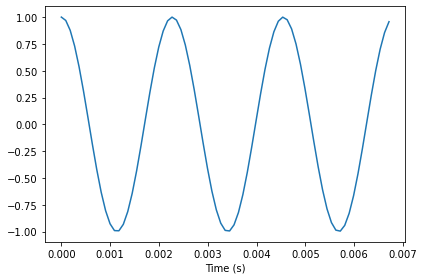

In [6]:
from thinkdsp import CosSignal, SinSignal, decorate

cos_sig = CosSignal(freq=440, amp=1.0, offset=0)
sin_sig = SinSignal(freq=880, amp=0.5, offset=0)

cos_sig.plot()  # plot the cosine
decorate(xlabel='Time (s)')

### Here is the sine signal

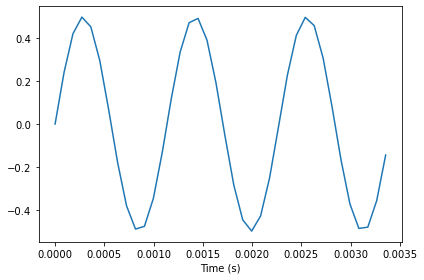

In [7]:
sin_sig.plot()
decorate(xlabel='Time (s)')

Notice that the frequency of the sine signal is doubled, so the period is halved.

### The sum of two signals is a SumSignal.

In [8]:
mix = sin_sig + cos_sig
mix

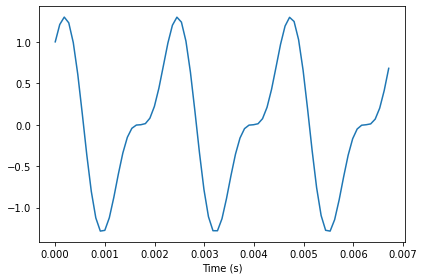

In [9]:
mix.plot()
decorate(xlabel='Time (s)')

#### Note that to actually work with these, the computer produces discrete digital signals

In [10]:
# evalute a signal at a particular 
sin_sig.evaluate([0,0.1,0.2])  

array([0.00000000e+00, 1.76448176e-14, 3.52896352e-14])

## Digital Signals 

A mathematical Signal represents a mathematical function defined for all values of time.  If you want to work with analog signals on a computer you need to represent discretely.

If you evaluate a signal at a sequence of equally-spaced times, the result is a typical digital signal (represented by a "Wave" object in thinkdsp).  Note `framerate` is the number of samples per second (usually called sample rate).

In [11]:
wave = mix.make_wave(duration=0.5, start=0, framerate=11025)
print(repr(wave))
wave.make_audio()
      

The `ys` attribute is a NumPy array that contains the values from the signal.  The interval between samples is the inverse of the framerate.

In [12]:
wave.ys[:10]

array([ 1.        ,  1.209102  ,  1.29840734,  1.22904103,  0.99112958,
        0.60791894,  0.1322604 , -0.36380845, -0.80398405, -1.12362026])

### important things about any finite waveform
Number of samples, sample rate, number of bits of representation

In [13]:
print('Number of samples', len(wave.ys))
print('Timestep in ms', 1 / wave.framerate * 1000)
print(f'{wave.ys.dtype=}')

Number of samples 5512
Timestep in ms 0.09070294784580499
wave.ys.dtype=dtype('float64')


`normalize` scales a wave so the range doesn't exceed -1 to 1.

`apodize` tapers the beginning and end of the wave so it doesn't click when you play it.

### Sound is reprented digital as just another type of waveform

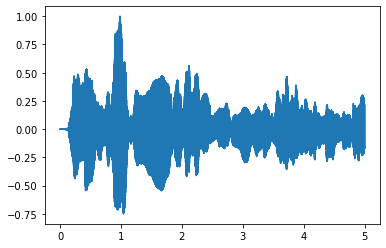

In [14]:
from thinkdsp import read_wave

wave = read_wave('92002__jcveliz__violin-origional.wav')
wave.plot()

In [15]:
wave.make_audio()

## Spectrums

Wave provides `make_spectrum`, which computes the spectrum of the wave.

In [16]:
start = 1.2
duration = 0.6
segment = wave.segment(start, duration)
spectrum = segment.make_spectrum()

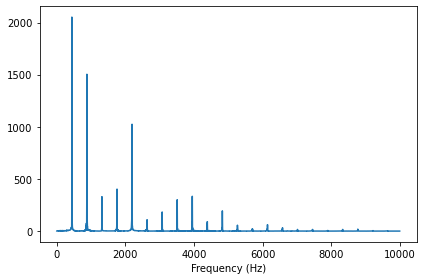

In [17]:
spectrum.plot(high=10000)
decorate(xlabel='Frequency (Hz)')

### Intro to filtering
Spectrum provides `low_pass`, which applies a low pass filter; that is, it attenuates all frequency components above a cutoff frequency.

In [18]:
spectrum.low_pass(3000)

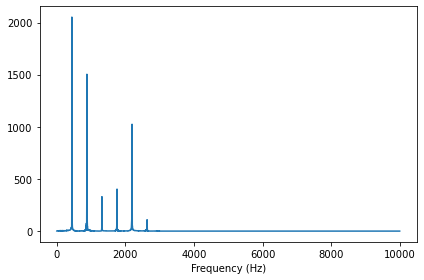

In [19]:
spectrum.plot(high=10000)
decorate(xlabel='Frequency (Hz)')

In [20]:
filtered = spectrum.make_wave()
filtered.normalize()

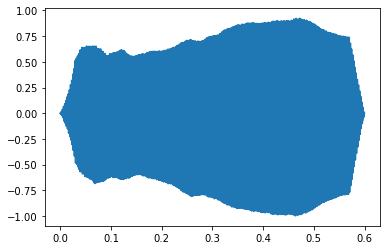

In [21]:
filtered.apodize()
filtered.plot()

### We can compare the filtered vs the original segment

In [22]:
filtered.make_audio()

In [23]:
segment.make_audio()

In [24]:
import matplotlib.pyplot as plt
from IPython.display import display

def filter_wave(wave, start, duration, cutoff):
    """Selects a segment from the wave and filters it.
    
    Plots the spectrum and displays an Audio widget.
    
    wave: Wave object
    start: time in s
    duration: time in s
    cutoff: frequency in Hz
    """
    segment = wave.segment(start, duration)
    spectrum = segment.make_spectrum()

    spectrum.plot(color='0.7')
    spectrum.low_pass(cutoff)
    spectrum.plot(color='#045a8d')
    decorate(xlabel='Frequency (Hz)')
    plt.show()
    
    audio = spectrum.make_wave().make_audio()
    display(audio)

Adjust the sliders to control the start and duration of the segment and the cutoff frequency applied to the spectrum.

In [25]:
from ipywidgets import interact, fixed

wave = read_wave('92002__jcveliz__violin-origional.wav')
interact(filter_wave, wave=fixed(wave), 
         start=(0, 5, 0.1), duration=(0, 10, 0.1), cutoff=(0, 10000, 100));

interactive(children=(FloatSlider(value=2.0, description='start', max=5.0), FloatSlider(value=5.0, description…

## Starting work with some EEG

EEG signals are digitized analog signals of the electric field on the head. 
The are handled similarly.

In [26]:
eeg1 = eeghdf.Eeghdf(fn)

In [27]:
brow1 = eegvis.nb_eegview.EeghdfBrowser(eeg1,montage='double banana', page_width_seconds=20)
brow1.show()

### They can be "visualized" or listened to in the same way
- Note EEG frequencies are much slower than most audible sounds, so I will speed up the EEG by 70x

In [28]:
w0  = thinkdsp.Wave(eeg1.phys_signals[7,0:1000*256], framerate=256*70)
w0.make_audio()

### We usually practice interpreting the visual versions of these signals


In [30]:
eegneosz5 = eeghdf.Eeghdf(fn2)

In [31]:
neosz5_sf, L_sec = eegneosz5.sample_frequency, eegneosz5.phys_signals.shape[1]/eegneosz5.sample_frequency
fs = neosz5_sf # default sammple refrequency
speedup = 70
print(f"sampling frequency (Hz): {neosz5_sf}, duration (sec): {L_sec}, type: {eegneosz5.rawsignals.dtype}")

sampling frequency (Hz): 256.0, duration (sec): 3841.0, type: int16


In [32]:
brow1 = eegvis.nb_eegview.EeghdfBrowser(eegneosz5, montage='neonatal', page_width_seconds=20)
brow1.show()

In [33]:
sz2interval_sec = (150, 840.0)
sz2interval_sample = int(sz2interval_sec[0]*neosz5_sf), int(sz2interval_sec[1]*neosz5_sf)
sz2interval_sample

(38400, 215040)

#### We can listen to the seizure vs non-seizure portions

In [35]:
[(ii, lab) for (ii, lab) in enumerate(eegneosz5.electrode_labels) 
if 'T3' in lab ]


[(7, 'EEG T3-Ref')]

In [36]:
eeg5t3 = eegneosz5.phys_signals[7,:]

In [37]:
w1 =thinkdsp.Wave(eeg5t3[:10000*3],framerate=fs * 70)
w1.make_audio()

In [38]:
w2  = thinkdsp.Wave(eeg5t3[sz2interval_sample[0]:sz2interval_sample[1]], framerate=fs*70)
w2.make_audio()

In [41]:
# wave = read_wave('92002__jcveliz__violin-origional.wav')
#interact(filter_wave, wave=fixed(wave), 
#         start=(0, 5, 0.1), duration=(0, 10, 0.1), cutoff=(0, 10000, 100));
interact(filter_wave, wave=fixed(w1), 
         start=(0, 5, 0.1), duration=(0, 10, 0.1), cutoff=(0, 10000, 100));

interactive(children=(FloatSlider(value=2.0, description='start', max=5.0), FloatSlider(value=5.0, description…

### If we have time, we can play around here

### Next time
- filtering
- aliasing



FIR : finite impulse response filters